
## Leveraging Qiskit


In [1]:
import pandas as pd
import networkx as nx
from qiskit_optimization.applications import Maxcut

data = pd.read_csv('./data/hero-network.csv')

heroes = {
    'MEDUSA/MEDUSALITH AM',
    'ARCLIGHT/PHILLIPA SO',
    'WOLVERINE/LOGAN ',
    'SCARLET WITCH/WANDA ',
    'ARAGORN',
    'OVERMIND/GROM',
    'BATTLEAXE/',
    'ION/',
    'PINK PEARL/'
}

relations = data[(data.hero1.isin(heroes)) & (data.hero2.isin(heroes))]
relations = pd.DataFrame(np.sort(relations.values, axis=1), columns=relations.columns).drop_duplicates(subset=['hero1', 'hero2'])

graph = nx.from_pandas_edgelist(relations, source='hero1', target='hero2')
matrix = nx.to_pandas_adjacency(graph, dtype=int)
adjacency = matrix.to_numpy()

max_cut = Maxcut(adjacency)
#CAPTION Formulating the problem

In [2]:
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))
#CAPTION Preparing the Ising Hamiltonian

Offset: -6.5
Ising Hamiltonian:
0.5 * IIIIIIIZZ
+ 0.5 * IIIIIIZIZ
+ 0.5 * IIIIIIZZI
+ 0.5 * IIIIIZIIZ
+ 0.5 * IIIIZIIIZ
+ 0.5 * IIIIZZIII
+ 0.5 * IIIZIIIZI
+ 0.5 * IIZZIIIII
+ 0.5 * IZIZIIIII
+ 0.5 * IZZIIIIII
+ 0.5 * ZIIZIIIII
+ 0.5 * ZIZIIIIII
+ 0.5 * ZZIIIIIII


In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(3, su2_gates=['ry', 'rz'], entanglement='linear', reps=1, insert_barriers=True)
qc = QuantumCircuit(3)  # create a circuit and append the RY variational form
qc.compose(ansatz, inplace=True)
qc.decompose().draw()
#CAPTION Preparing an ansatz

┌──────────┐┌──────────┐ ░            ░ ┌──────────┐ ┌──────────┐
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├─░───■────────░─┤ Ry(θ[6]) ├─┤ Rz(θ[9]) ├
     ├──────────┤├──────────┤ ░ ┌─┴─┐      ░ ├──────────┤┌┴──────────┤
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├─░─┤ X ├──■───░─┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├
     ├──────────┤├──────────┤ ░ └───┘┌─┴─┐ ░ ├──────────┤├───────────┤
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├─░──────┤ X ├─░─┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├
     └──────────┘└──────────┘ ░      └───┘ ░ └──────────┘└───────────┘

In [8]:
ansatz = EfficientSU2(4, su2_gates=[], entanglement='circular', reps=1)
qc = QuantumCircuit(4)  # create a circuit and append the RY variational form
qc.compose(ansatz, inplace=True)
qc.decompose().draw()
#CAPTION The circular entanglement

┌───┐               
q_0: ┤ X ├──■────────────
     └─┬─┘┌─┴─┐          
q_1: ──┼──┤ X ├──■───────
       │  └───┘┌─┴─┐     
q_2: ──┼───────┤ X ├──■──
       │       └───┘┌─┴─┐
q_3: ──■────────────┤ X ├
                    └───┘

In [9]:
ansatz = EfficientSU2(4, su2_gates=[], entanglement='full', reps=1)
qc = QuantumCircuit(4)  # create a circuit and append the RY variational form
qc.compose(ansatz, inplace=True)
qc.decompose().draw()
#CAPTION The full entanglement

q_0: ──■────■─────────■────────────
     ┌─┴─┐  │         │            
q_1: ┤ X ├──┼────■────┼────■───────
     └───┘┌─┴─┐┌─┴─┐  │    │       
q_2: ─────┤ X ├┤ X ├──┼────┼────■──
          └───┘└───┘┌─┴─┐┌─┴─┐┌─┴─┐
q_3: ───────────────┤ X ├┤ X ├┤ X ├
                    └───┘└───┘└───┘

In [11]:
ansatz = EfficientSU2(4, su2_gates=[], entanglement='sca', reps=3, insert_barriers=True)
qc = QuantumCircuit(4)  # create a circuit and append the RY variational form
qc.compose(ansatz, inplace=True)
qc.decompose().draw()
#CAPTION The 'sca' entanglement

┌───┐                ░           ┌───┐      ░           ┌───┐      ░ 
q_0: ┤ X ├──■─────────────░────────■──┤ X ├──────░───────────┤ X ├──■───░─
     └─┬─┘┌─┴─┐           ░        │  └─┬─┘┌───┐ ░           └─┬─┘┌─┴─┐ ░ 
q_1: ──┼──┤ X ├──■────────░────────┼────■──┤ X ├─░───■─────────┼──┤ X ├─░─
       │  └───┘┌─┴─┐      ░ ┌───┐  │       └─┬─┘ ░ ┌─┴─┐       │  └───┘ ░ 
q_2: ──┼───────┤ X ├──■───░─┤ X ├──┼─────────■───░─┤ X ├──■────┼────────░─
       │       └───┘┌─┴─┐ ░ └─┬─┘┌─┴─┐           ░ └───┘┌─┴─┐  │        ░ 
q_3: ──■────────────┤ X ├─░───■──┤ X ├───────────░──────┤ X ├──■────────░─
                    └───┘ ░      └───┘           ░      └───┘           ░

In [12]:
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms import VQE
from qiskit.utils import QuantumInstance

# create a reusable backend
backend = Aer.get_backend("statevector_simulator")

# hold backend and configuration
quantum_instance = QuantumInstance(backend)

# the optimizer
spsa = SPSA(maxiter=300)

# the solution ansatz
ansatz = EfficientSU2(qubitOp.num_qubits, su2_gates=['ry', 'rz'], entanglement='linear', reps=3)

# the overall VQE
vqe = VQE(ansatz, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE with the Ising Hamiltonian in qubitOp
result = vqe.compute_minimum_eigenvalue(qubitOp)
#CAPTION The overall VQE

In [13]:
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)

solution = max_cut.sample_most_likely(result.eigenstate)
print("solution:", solution)
print("solution objective:", qp.objective.evaluate(solution))

energy: -2.3812152141008314
time: 11.49511194229126
solution: [1. 0. 1. 0. 1. 1. 0. 1. 0.]
solution objective: 9.0


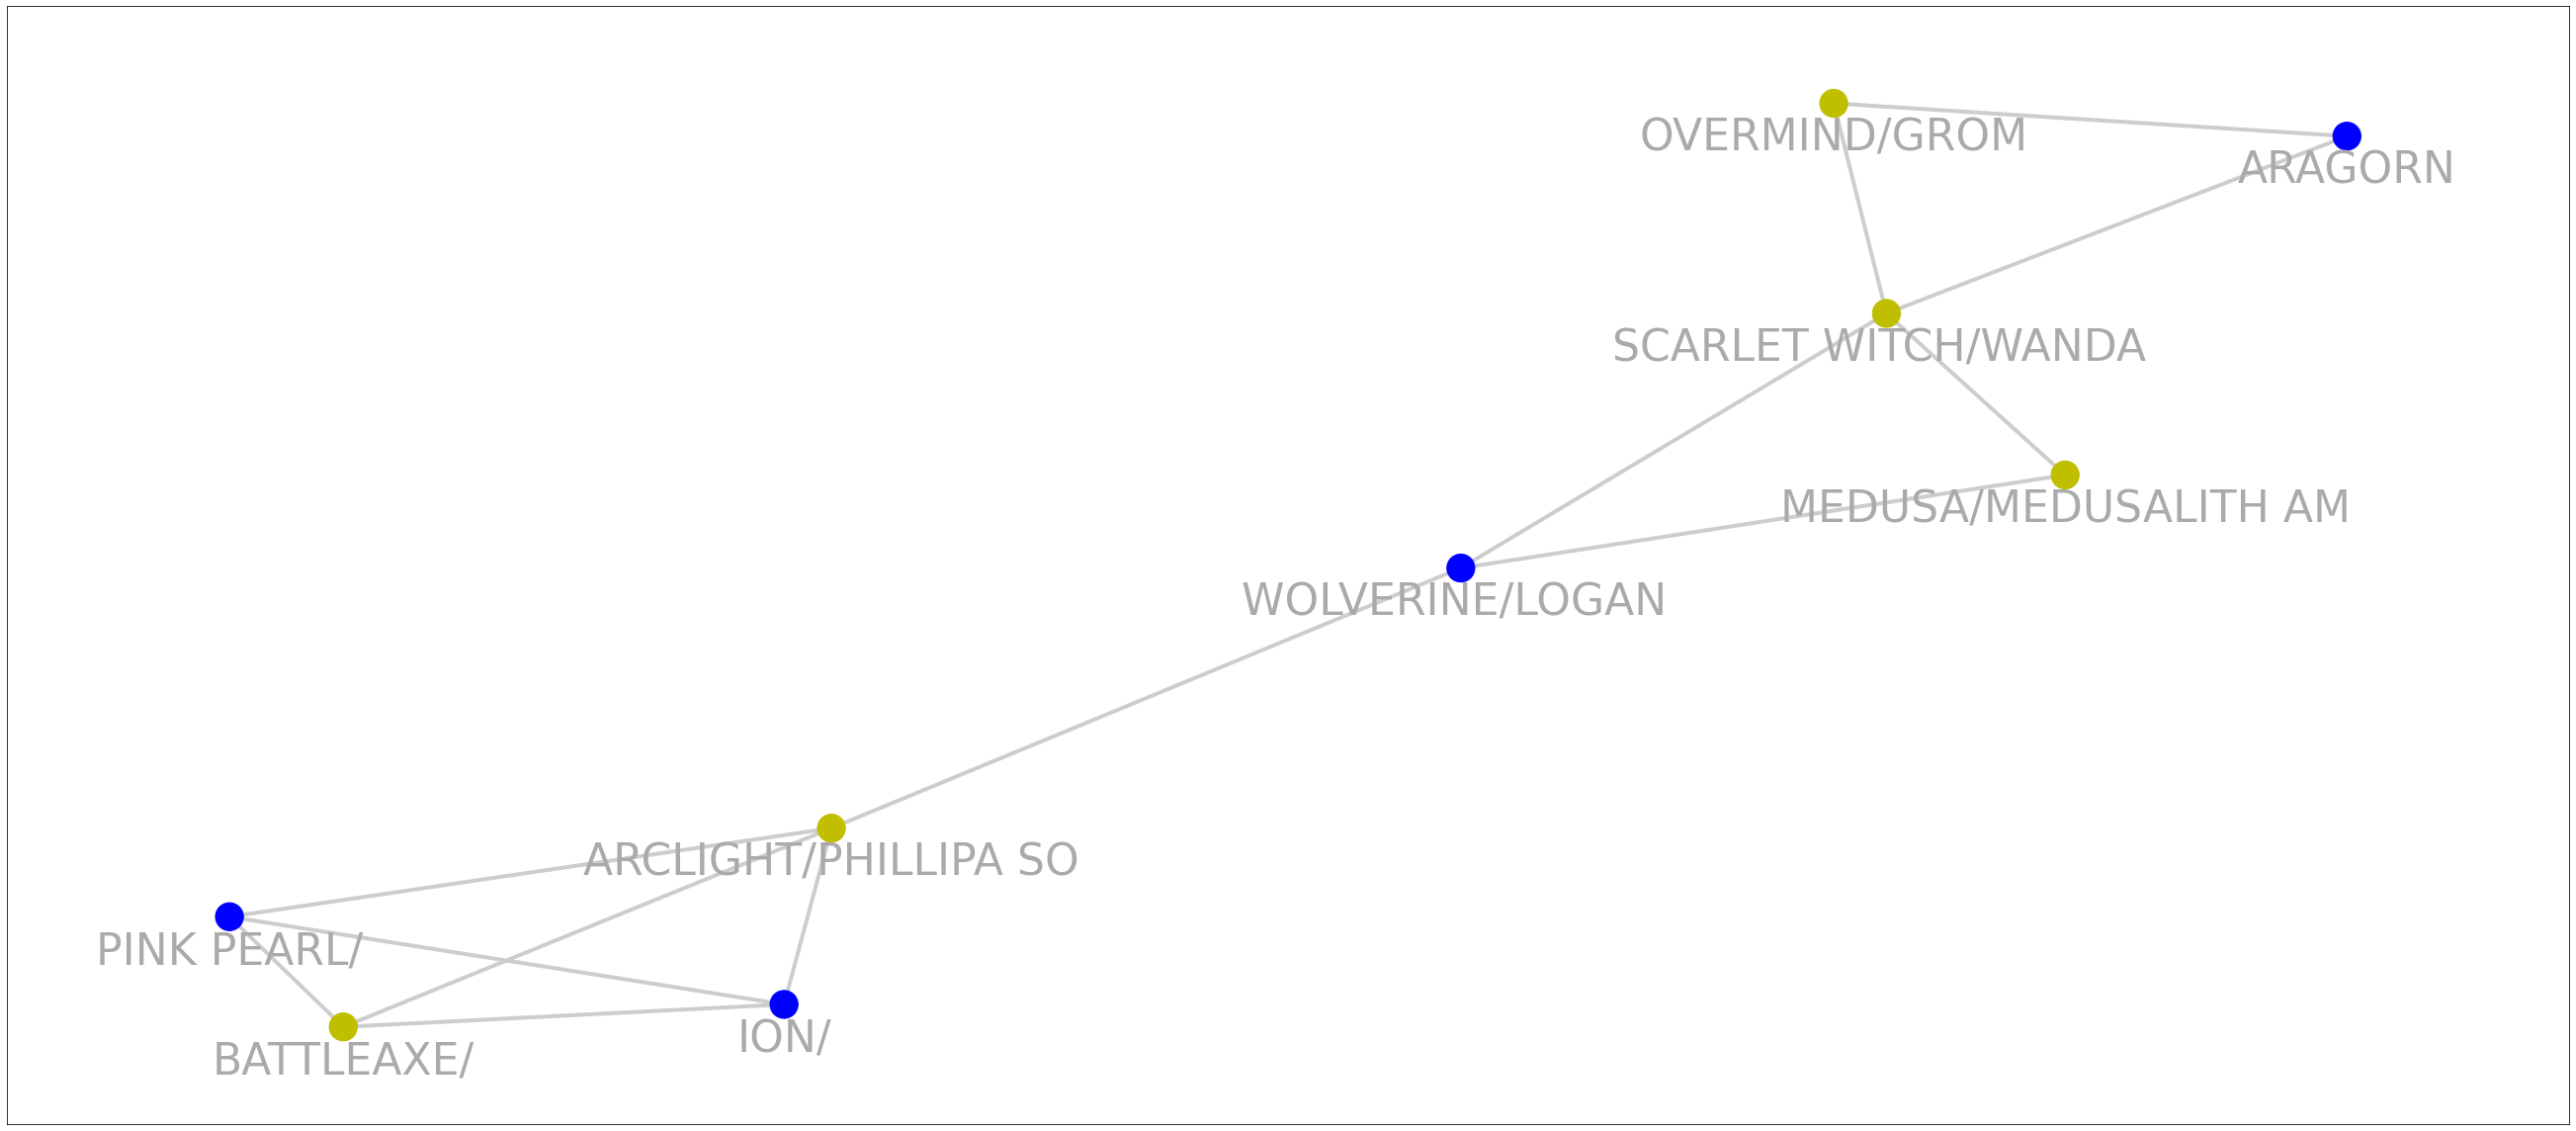

In [14]:
plt.figure(1,figsize=(12,2.5)) 
plt.tight_layout()
plt.subplots_adjust(bottom=-5.4, right=1.5, left=-1.5)
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

pos = nx.spring_layout(graph)
pos_nodes = nudge(pos, 0, -0.07)

colors = ["b" if solution[i] == 0 else "y" for i in range(qubitOp.num_qubits)]

nx.draw_networkx_nodes(graph, pos=pos, node_color=colors, node_size=800)   # default nodes and edges
nx.draw_networkx_edges(graph, pos, width=4, edge_color ="#CDCDCD")
labels=nx.draw_networkx_labels(graph,pos=pos_nodes, font_color="#AAA", font_size=44)
#CAPTION Visualizing the results and the solution